<a href="https://colab.research.google.com/github/Daz-Riza-Seriog/Tensorflow_ML/blob/main/1-Introduction%20to%20Tensorflow/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [ ]:
import tensorflow as tf
from scipy.io import loadmat

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [ ]:
# Run this cell to connect to your Drive folder

#from google.colab import drive
#drive.mount('/content/gdrive')

!rm -r checkpoints_best_only

In [ ]:
# Load the dataset from your Drive folder or using urllib
!wget "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
!wget "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"

train = loadmat('/content/train_32x32.mat')
test = loadmat('/content/test_32x32.mat')

--2023-02-27 02:36:31--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat.1’

train_32x32.mat.1   100%[===================>] 173.61M  25.3MB/s    in 7.7s    

2023-02-27 02:36:39 (22.5 MB/s) - ‘train_32x32.mat.1’ saved [182040794/182040794]

--2023-02-27 02:36:39--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat.1’

test_32x32.mat.1    100%[===================>]  61.30M  21.9MB/s    in 2.8s    

2023-02-27 02:36:42 (21.9 MB/s) - ‘test_32x32.mat.1’ saved [642

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you. ¤
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure. ¤
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._¤
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.¤

In [ ]:
# Extract train set
x_train = train["X"]
y_train = train["y"]

# Extract test set
x_test = test["X"]
y_test = test["y"]


<function matplotlib.pyplot.show(close=None, block=None)>

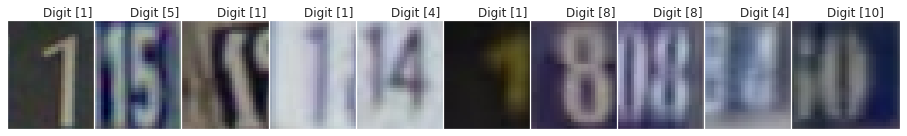

In [ ]:
num_test_images = x_train.shape[3]

num_img=10
random_inx = np.random.choice(num_test_images, num_img)
random_test_images = x_train[...,random_inx]
random_test_labels = y_train[random_inx]

fig, axes = plt.subplots(1,10, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i in np.arange(num_img):

  img = random_test_images[:, :, :, i]
  lbl = random_test_labels[i]

  axes[i].imshow(img)
  axes[i].get_xaxis().set_visible(False)
  axes[i].get_yaxis().set_visible(False)
  axes[i].text(10., -1.5, f'Digit {lbl}')
   
plt.show

In [ ]:
# We must reshape the train in a convenient form
# Note the shape is (32,32,3,72528)-> We pass the tird location to first

x_train = np.transpose(x_train,(3,0,1,2))
x_test = np.transpose(x_test,(3,0,1,2))

x_train.shape

(73257, 32, 32, 3)

In [ ]:
# now we normalize the vectors, currently for RGB is 255

x_train = x_train/255
x_test = x_test/255

x_train[0]

array([[[0.12941176, 0.11764706, 0.14901961],
        [0.05882353, 0.09019608, 0.0745098 ],
        [0.05882353, 0.06666667, 0.0745098 ],
        ...,
        [0.28235294, 0.25490196, 0.21960784],
        [0.32156863, 0.30196078, 0.22352941],
        [0.34901961, 0.30980392, 0.23137255]],

       [[0.10980392, 0.15294118, 0.1372549 ],
        [0.05490196, 0.09803922, 0.08627451],
        [0.05490196, 0.07843137, 0.06666667],
        ...,
        [0.15686275, 0.15294118, 0.19607843],
        [0.2627451 , 0.22745098, 0.20392157],
        [0.3254902 , 0.30588235, 0.23529412]],

       [[0.15686275, 0.16078431, 0.14901961],
        [0.07058824, 0.08235294, 0.10196078],
        [0.0627451 , 0.06666667, 0.09019608],
        ...,
        [0.09019608, 0.11372549, 0.17647059],
        [0.1372549 , 0.16470588, 0.17254902],
        [0.28235294, 0.27058824, 0.20784314]],

       ...,

       [[0.3372549 , 0.31764706, 0.29411765],
        [0.34117647, 0.32156863, 0.27843137],
        [0.32156863, 0

In [ ]:
# You must change the label 10 to 0, for avoid Error =Received a label value of 10 which is outside the valid range of [0, 10) in the fit

y_train[y_train==10] = 0
y_test[y_test==10] = 0

In [ ]:
# Convert x_train images to Gray scale

x_train_g = np.mean(x_train,keepdims=True,axis=-1) # We select the last axis fot the channels,and mantain dthe dimension
x_test_g = np.mean(x_test,keepdims=True,axis=-1)

x_train_g.shape

(73257, 32, 32, 1)

<function matplotlib.pyplot.show(close=None, block=None)>

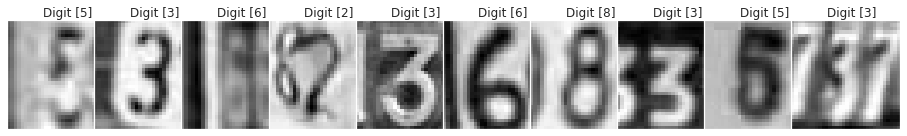

In [ ]:
num_test_images = x_train_g.shape[0]
num_img=10
random_inx = np.random.choice(num_test_images, num_img)
random_test_images = x_train_g[random_inx,...]
random_test_labels = y_train[random_inx]

fig2, axes = plt.subplots(1,10, figsize=(16, 12))
fig2.subplots_adjust(hspace=0.4, wspace=-0.2)

for i in np.arange(num_img):

  img = random_test_images[i, :, :, :]
  lbl = random_test_labels[i]

  axes[i].imshow(img,cmap="gray")
  axes[i].get_xaxis().set_visible(False)
  axes[i].get_yaxis().set_visible(False)
  axes[i].text(10., -1.5, f'Digit {lbl}')
   
plt.show

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [ ]:
# Delete model

del model
del model_CNN

NameError: ignored

In [ ]:
# Create the model

def get_MPL_model():
  Sequential = tf.keras.models.Sequential
  Dense = tf.keras.layers.Dense
  Flatten = tf.keras.layers.Flatten

  input_shape = x_train_g[0].shape
  model = Sequential([
      Flatten(input_shape=input_shape,name="Flatten"),
      Dense(units=64,activation="relu",kernel_initializer="he_uniform",bias_initializer="ones", name="Dense_1"),
      Dense(units=32,activation="relu",name="Dense_2"),
      Dense(units=16,activation="relu",name="Dense_3"),
      Dense(units=10,activation="softmax",name="Dense_4")
      ])
  
  # Compile the Model
  opt = tf.keras.optimizers.Adam()
  lss = tf.keras.losses.SparseCategoricalCrossentropy()
  acc = tf.keras.metrics.SparseCategoricalAccuracy()
  model.compile(optimizer=opt,loss=lss,metrics=[acc])

  return model

In [ ]:
#Summary of the model
model = get_MPL_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten (Flatten)           (None, 1024)              0         
                                                                 
 Dense_1 (Dense)             (None, 64)                65600     
                                                                 
 Dense_2 (Dense)             (None, 32)                2080      
                                                                 
 Dense_3 (Dense)             (None, 16)                528       
                                                                 
 Dense_4 (Dense)             (None, 10)                170       
                                                                 
Total params: 68,378
Trainable params: 68,378
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Create Early Stopping & ModelCheckpoint ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

earlyStopping = EarlyStopping(monitor="val_sparse_categorical_accuracy",patience=3)

checkpoint_best_only_path_MPL = "checkpoints_best_only_MPL/checkpoint"
checkpoint_best_only_MPL = ModelCheckpoint(filepath=checkpoint_best_only_path_MPL,
                                       save_weights_only = True,
                                       monitor = "val_sparse_categorical_accuracy",
                                       save_best_only=True,
                                       verbose=True)

In [ ]:
# Fit the model with callback
callbacks=[checkpoint_best_only_MPL,earlyStopping]
History = model.fit(x_train_g, y_train, epochs=30, validation_split=0.15,batch_size=40,callbacks=callbacks)

Epoch 1/30
1551/1557 [============================>.] - ETA: 0s - loss: 2.1268 - sparse_categorical_accuracy: 0.2210
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.36864, saving model to checkpoints_best_only_MPL/checkpoint
1557/1557 [==============================] - 10s 6ms/step - loss: 2.1261 - sparse_categorical_accuracy: 0.2212 - val_loss: 1.7859 - val_sparse_categorical_accuracy: 0.3686
Epoch 2/30
1553/1557 [============================>.] - ETA: 0s - loss: 1.6092 - sparse_categorical_accuracy: 0.4376
Epoch 2: val_sparse_categorical_accuracy improved from 0.36864 to 0.48640, saving model to checkpoints_best_only_MPL/checkpoint
1557/1557 [==============================] - 7s 5ms/step - loss: 1.6087 - sparse_categorical_accuracy: 0.4378 - val_loss: 1.4887 - val_sparse_categorical_accuracy: 0.4864
Epoch 3/30
1556/1557 [============================>.] - ETA: 0s - loss: 1.4017 - sparse_categorical_accuracy: 0.5289
Epoch 3: val_sparse_categorical_accuracy improved fro

In [ ]:
# Create a DataFrame for History

df_history = pd.DataFrame(History.history)
df_history.head(5) 

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
0,2.126108,0.221221,1.785890,0.368641
1,1.608702,0.437817,1.488719,0.486395
2,1.401565,0.528972,1.349777,0.552280
3,1.262231,0.590753,1.233715,0.600783
4,1.176737,0.621989,1.193161,0.619256


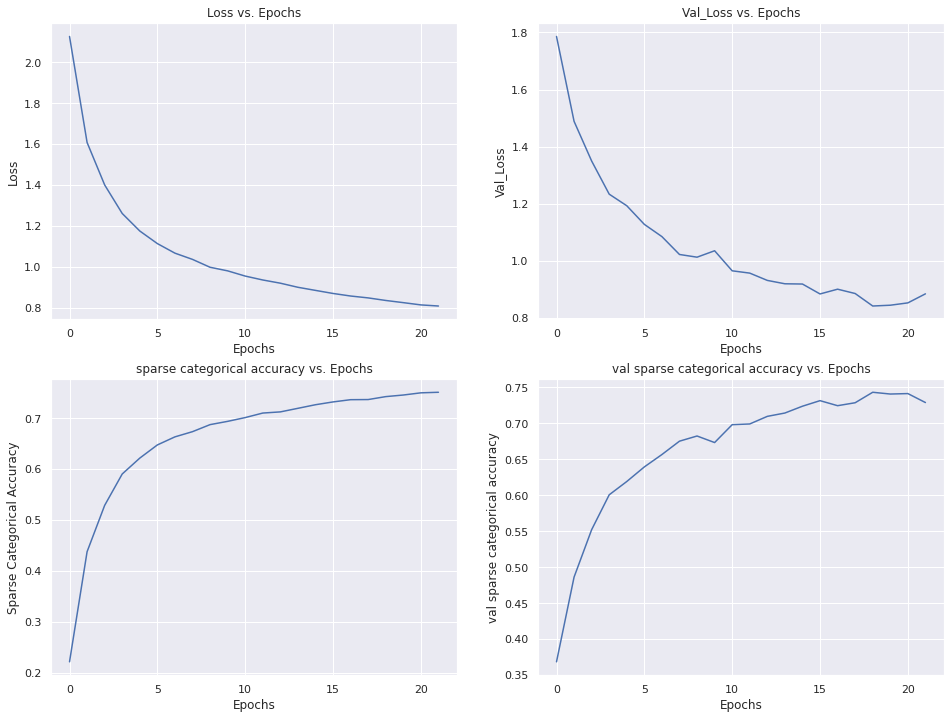

In [ ]:
# Plot loss vs Epochs in training and validation sets


fig3, axes = plt.subplots(2,2, figsize=(16, 12))

loss_plot_training = df_history.plot(y='loss', title='Loss vs. Epochs', legend=False,ax=axes[0,0])
loss_plot_training.set(xlabel="Epochs", ylabel="Loss")

loss_plot_valid = df_history.plot(y='val_loss', title='Val_Loss vs. Epochs', legend=False,ax=axes[0,1])
loss_plot_valid.set(xlabel="Epochs", ylabel="Val_Loss")

acc_plot_training = df_history.plot(y='sparse_categorical_accuracy', title='sparse categorical accuracy vs. Epochs', legend=False,ax=axes[1,0])
acc_plot_training.set(xlabel="Epochs", ylabel="Sparse Categorical Accuracy")

acc_plot_valid = df_history.plot(y='val_sparse_categorical_accuracy', title='val sparse categorical accuracy vs. Epochs', legend=False,ax=axes[1,1])
acc_plot_valid.set(xlabel="Epochs", ylabel="val sparse categorical accuracy")

plt.show()



In [ ]:
# Evaluate the model with the test set

test_loss,test_accuarcy = model.evaluate(x_test_g,y_test)

814/814 [==============================] - 2s 2ms/step - loss: 0.9912 - sparse_categorical_accuracy: 0.7076


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [ ]:
# Create the model CNN

def get_CNN_model():
  Conv2D = tf.keras.layers.Conv2D
  MaxPool2D = tf.keras.layers.MaxPooling2D
  BatchNorm = tf.keras.layers.BatchNormalization
  Dropout = tf.keras.layers.Dropout
  
  input_shape2 = x_train[0].shape
  model_CNN = Sequential([
      Conv2D(filters=16,kernel_size=(3,3),activation="relu",padding="same",input_shape=input_shape2,data_format="channels_last",name="conv_1"),
      Conv2D(filters=8,kernel_size=(3,3),activation="relu",padding="same",name="conv_2"),
      BatchNorm(),
      MaxPool2D(pool_size=(4, 4), name='pool_1'),
      Flatten(name='flatten'),
      Dense(units=16,activation="relu",name="Dense_1"),
      Dense(units=10,activation="softmax",name="Dense_2")
      ])
  
  # Compile the Model
  opt = tf.keras.optimizers.Adam()
  lss = tf.keras.losses.SparseCategoricalCrossentropy()
  acc = tf.keras.metrics.SparseCategoricalAccuracy()
  model_CNN.compile(optimizer=opt,loss=lss,metrics=[acc])

  return model_CNN
  


In [ ]:
model_CNN = get_CNN_model()
model_CNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 conv_2 (Conv2D)             (None, 32, 32, 8)         1160      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 8)        32        
 hNormalization)                                                 
                                                                 
 pool_1 (MaxPooling2D)       (None, 8, 8, 8)           0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 Dense_1 (Dense)             (None, 16)                8208      
                                                      

In [ ]:
# Fit the model with the same Callbacks
checkpoint_best_only_path_CNN = "checkpoints_best_only_CNN/checkpoint"
checkpoint_best_only_CNN = ModelCheckpoint(filepath=checkpoint_best_only_path_CNN,
                                       save_weights_only = True,
                                       monitor = "val_sparse_categorical_accuracy",
                                       save_best_only=True,
                                       verbose=True)

callbacks=[checkpoint_best_only_CNN,earlyStopping]

History2 = model_CNN.fit(x_train, y_train, epochs=30, validation_split=0.15,batch_size=40,callbacks=callbacks)

Epoch 1/30
1557/1557 [==============================] - ETA: 0s - loss: 1.3851 - sparse_categorical_accuracy: 0.5366
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.73874, saving model to checkpoints_best_only_CNN/checkpoint
1557/1557 [==============================] - 139s 88ms/step - loss: 1.3851 - sparse_categorical_accuracy: 0.5366 - val_loss: 0.8567 - val_sparse_categorical_accuracy: 0.7387
Epoch 2/30
1557/1557 [==============================] - ETA: 0s - loss: 0.7653 - sparse_categorical_accuracy: 0.7695
Epoch 2: val_sparse_categorical_accuracy improved from 0.73874 to 0.76431, saving model to checkpoints_best_only_CNN/checkpoint
1557/1557 [==============================] - 161s 103ms/step - loss: 0.7653 - sparse_categorical_accuracy: 0.7695 - val_loss: 0.7816 - val_sparse_categorical_accuracy: 0.7643
Epoch 3/30
1556/1557 [============================>.] - ETA: 0s - loss: 0.6998 - sparse_categorical_accuracy: 0.7902
Epoch 3: val_sparse_categorical_accuracy improv

In [ ]:
# Create a DataFrame for History

df_history_cnn = pd.DataFrame(History2.history)
df_history_cnn.head(5) 

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
0,1.385102,0.536568,0.856671,0.738739
1,0.765316,0.769529,0.781561,0.764310
2,0.699701,0.790197,0.700856,0.791155
3,0.657408,0.801808,0.661875,0.797525
4,0.632007,0.806562,0.685654,0.793612


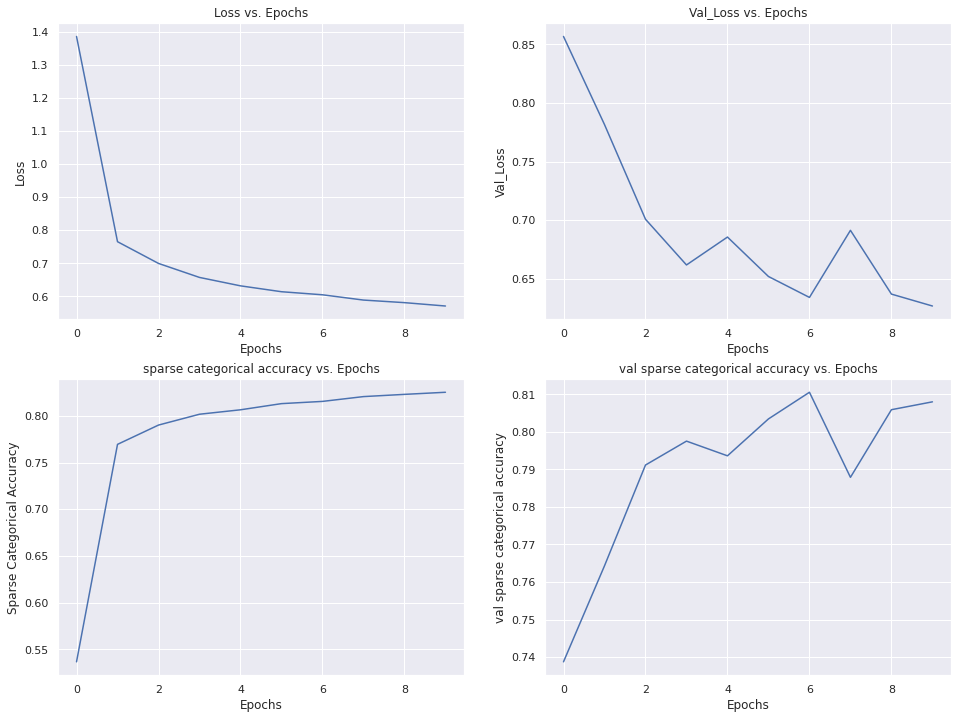

In [ ]:
# Plot loss vs Epochs in training and validation sets


fig4, axes = plt.subplots(2,2, figsize=(16, 12))

loss_plot_training_cnn = df_history_cnn.plot(y='loss', title='Loss vs. Epochs', legend=False,ax=axes[0,0])
loss_plot_training_cnn.set(xlabel="Epochs", ylabel="Loss")

loss_plot_valid_cnn = df_history_cnn.plot(y='val_loss', title='Val_Loss vs. Epochs', legend=False,ax=axes[0,1])
loss_plot_valid_cnn.set(xlabel="Epochs", ylabel="Val_Loss")

acc_plot_training_cnn = df_history_cnn.plot(y='sparse_categorical_accuracy', title='sparse categorical accuracy vs. Epochs', legend=False,ax=axes[1,0])
acc_plot_training_cnn.set(xlabel="Epochs", ylabel="Sparse Categorical Accuracy")

acc_plot_valid_cnn = df_history_cnn.plot(y='val_sparse_categorical_accuracy', title='val sparse categorical accuracy vs. Epochs', legend=False,ax=axes[1,1])
acc_plot_valid_cnn.set(xlabel="Epochs", ylabel="val sparse categorical accuracy")

plt.show()


In [ ]:
# Evaluate the model with the test set

test_loss,test_accuarcy = model_CNN.evaluate(x_test,y_test)

814/814 [==============================] - 15s 18ms/step - loss: 0.7345 - sparse_categorical_accuracy: 0.7802


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [ ]:
# Load the best weight in a new model MPL
model3 = get_MPL_model()
model3.load_weights(checkpoint_best_only_path_MPL)

In [ ]:
# Load the best weight in a new model CNN
model4 = get_CNN_model()
model4.load_weights(checkpoint_best_only_path_CNN)

1/1 [==============================] - 0s 30ms/step


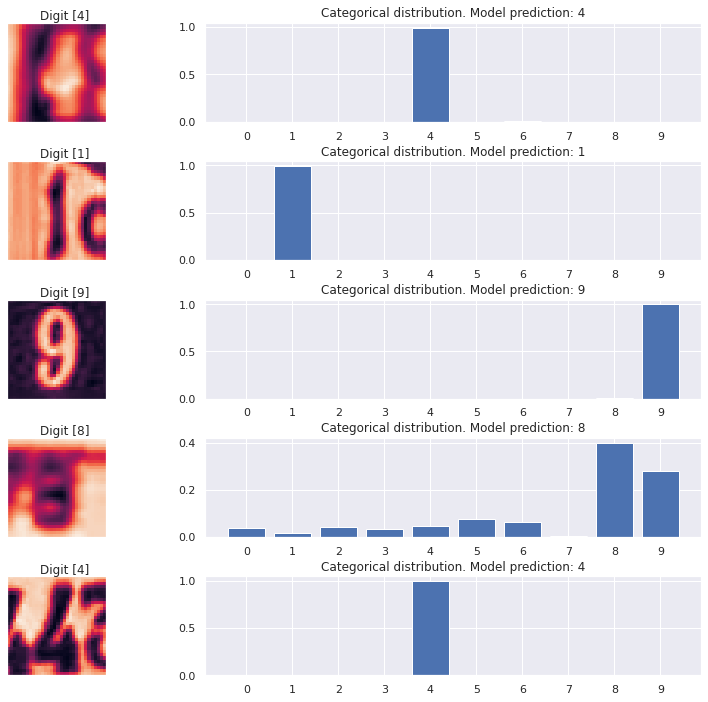

In [ ]:
# Plot model predictions on randomly selected test images in gray

num_test_images = x_test_g.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = x_test_g[random_inx, ...]
random_test_labels = y_test[random_inx]

predictions = model.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(image)
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
    
plt.show()

1/1 [==============================] - 0s 30ms/step


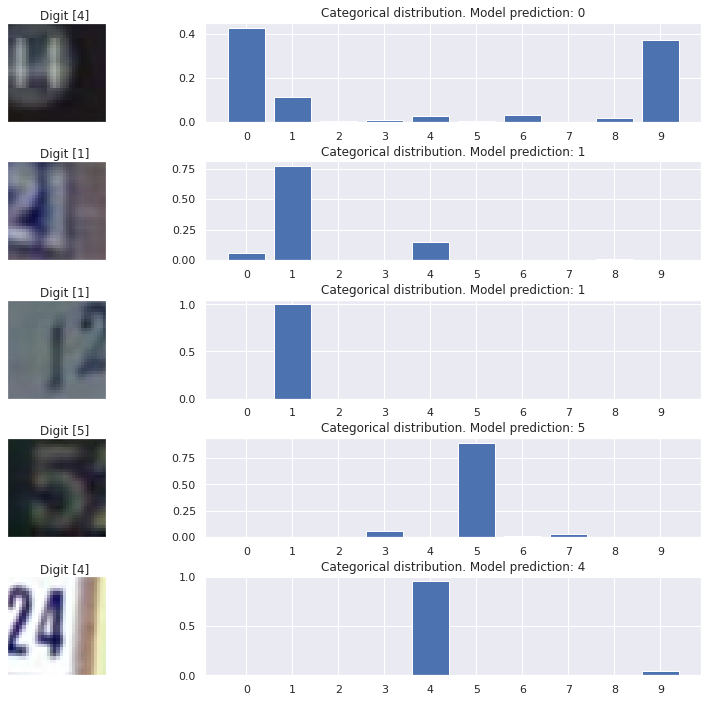

In [ ]:
# Plot model predictions on randomly selected test images 

num_test_images = x_test.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = x_test[random_inx, ...]
random_test_labels = y_test[random_inx]

predictions = model_CNN.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(image)
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
    
plt.show()